In [1]:
!pip install nltk

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [81]:
import numpy as np 
import pandas as pd    
import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize

import squad_preprocess as prepro

import tensorflow as tf

#data_dir = 'paraphrase-id-tensorflow-master/data/raw/'
data_dir = 'data/'
train = pd.read_csv(data_dir + "train.csv", encoding="utf-8")
pre_len = train.shape[0]
train = train.dropna(how = 'any')
post_len = train.shape[0]
train.head()

[nltk_data] Downloading package punkt to /Users/Arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Arnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
# small sample dataset
small = train.sample(n = 10)
small.tail(30)

,id,qid1,qid2,question1,question2,is_duplicate
29169,29169,54004,54005,What would be a strategy to write answers in a...,What is the per question weightage (marks) in ...,0
300528,300528,423347,423348,What are uses for Darmstadtium?,What are the uses of Darmstadtium?,1
9929,9929,19281,19282,How would someone start there own political pa...,What are tricks for writing essays and intervi...,0
286454,286454,407043,407044,What do you think life is about?,What do you think life is?,1
110407,110407,181022,181023,What is the length of the bond at yodlee and w...,How much higher can the demand for 30-year T-b...,0
245953,245953,358903,358904,"I am a law student in India, wanting to pursue...",I want to pursue filmmaking. I am in 11th grad...,0
199755,199755,301329,301330,What is the oldest man made structure that is ...,What are the oldest man-made structures still ...,1
203519,203519,306169,306170,Is there a way for a tank crew to use the toil...,Do tanks have toilets?,0
376420,376420,507560,507561,If you own a piece of land and there is an vol...,Should I really be making career decisions now?,0
375782,375782,112726,87798,How can you trace a phone call legally?,How do I trace a phone call?,1


In [18]:
def remove(sentence, regex, lemmatize = False):
    #[^a-zA-Z]
    #print(sentence)
    ret = sentence
    #ret = re.sub(regex,' ', ret)
    
    ret = ret.lower()
    
    ret = word_tokenize(ret) #uses punkt tokenizer
    
    #ps = PorterStemmer()
    #ret = [ps.stem(x) for x in ret]
    
    if lemmatize:
        wnl = WordNetLemmatizer()
        ret = [wnl.lemmatize(x) for x in ret]
    
    return ret

def remove_dcn(sentence, lemmatize = False):
    #[^a-zA-Z]
    ret = sentence
    ret = ret.lower()
    
    ret = prepro.tokenize(ret) #uses punkt tokenizer
    if lemmatize:
        wnl = WordNetLemmatizer()
        ret = [wnl.lemmatize(x) for x in ret]
    
    return ret

ind = 5
print(small['question1'].apply(lambda x: remove(x, "")).iloc[ind])
print(small['question1'].apply(lambda x: remove_dcn(x)).iloc[ind])

[u'i', u'am', u'a', u'law', u'student', u'in', u'india', u',', u'wanting', u'to', u'pursue', u'a', u'career', u'in', u'graphic', u'design', u'.', u'i', u'am', u'currently', u'freelancing', u'.', u'what', u'courses', u'can', u'i', u'opt', u'for', u'after', u'my', u'degree', u'?']
[u'i', u'am', u'a', u'law', u'student', u'in', u'india', u',', u'wanting', u'to', u'pursue', u'a', u'career', u'in', u'graphic', u'design', u'.', u'i', u'am', u'currently', u'freelancing', u'.', u'what', u'courses', u'can', u'i', u'opt', u'for', u'after', u'my', u'degree', u'?']


In [19]:
# Make Dictionary of id to unique, cleaned questions 
# Also fill dictionary with encountered words

id2q = {}
vocab = {}
for index, row in train.iterrows():
    if not row['qid1'] in id2q:
        word_list = remove_dcn(row['question1'])
        vocab.update({v:1 for v in word_list})
        id2q[row['qid1']] = word_list
    if not row['qid2'] in id2q:
        word_list = remove_dcn(row['question2'])
        vocab.update({v:1 for v in word_list})
        id2q[row['qid2']] = word_list


In [82]:
thresh = 26
L = 0
for index, row in train.iterrows():
    mask = (len(id2q[row['qid1']]) < thresh) & (len(id2q[row['qid2']]) < thresh)
    if mask:
        L += 1
print("Percent of Data after Filtering: " + str(1.*(L)/post_len))
print(L, post_len)

Percent of Data after Filtering: 0.913257380877
(369219, 404288)


In [25]:
print("Number of Unique Questions: " + str(len(id2q)))
#print(id2q[80])
#print(id2q[667])
#print(id2q[663])

print("")
print("Unique Vocab Size " + str(len(vocab)))

Number of Unique Questions: 537931

Unique Vocab Size 113573


In [26]:
# Import Glove Embeddings 
import io 

In [40]:
# write GloVe vocab to textfile
def record_vocab(file, file_name):
    to_write = io.open(file_name, 'a', encoding="utf-8")
    
    for line in f:
        values = line.split()
        word = values[0]
        to_write.write(word+'\n')
        pass
    to_write.close()
    return 
# load the whole embedding into memory
glove_dir = "paraphrase-id-tensorflow-master/data/external/"
f = io.open(glove_dir + 'glove.6B.100d.txt', mode='r', encoding="utf-8")
record_vocab(f, glove_dir + 'glove_vocab.txt')
f.close()

In [41]:
# load the whole embedding into memory
embeddings_dir = "dynamic-coattention-network-plus/download/dwr/"
f = io.open(embeddings_dir + 'glove.6B.100d.txt', mode='r', encoding="utf-8")
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    if word in vocab:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs
    pass
print('Loaded %s word vectors.' % len(embeddings))
f.close()

Loaded 64761 word vectors.


In [42]:
avg_oov_per_q = 0
avg_oov_ratio_per_q = 0
qs_with_oov = 0
avg_oov_q_with_oov = 0
oov_counts = []
q_count = len(id2q)
for v in id2q.values():
    oov_count = 0
    oov_ratio = 1
    for w in v:
        if not w in embeddings:
            oov_count += 1.
        pass
    avg_oov_per_q += oov_count/q_count
    avg_oov_q_with_oov += int(oov_count > 0.5)*oov_count
    
    if oov_count>.5:
        oov_counts.append(oov_count)
    
    avg_oov_ratio_per_q += (oov_count/len(v))/q_count
    qs_with_oov += int(oov_count > 0.5)
    
    pass

print("Average OOV Count Per Quesiton: " + str(avg_oov_per_q))
print("Average OOV Count For Questions with an OOV: " + str(avg_oov_q_with_oov/qs_with_oov))
print("Median OOV Count For Questions with an OOV: " + str(np.median(oov_counts)))

print("Average OOV Ratio Per Quesiton: " + str(avg_oov_ratio_per_q))
print("Fraction of Quesitons with OOV: " + str(1.*qs_with_oov/q_count))


Average OOV Count Per Quesiton: 0.153153471356
Average OOV Count For Questions with an OOV: 1.26778899421
Median OOV Count For Questions with an OOV: 1.0
Average OOV Ratio Per Quesiton: 0.0118761750565
Fraction of Quesitons with OOV: 0.120803597487


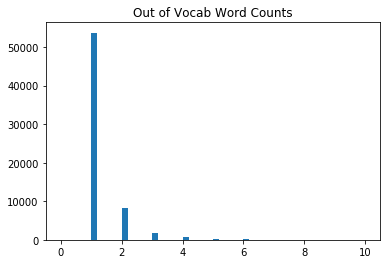

In [46]:
from matplotlib import pyplot as plt
plt.hist(oov_counts, 50, range = (0,10))
plt.title('Out of Vocab Word Counts')
plt.show()

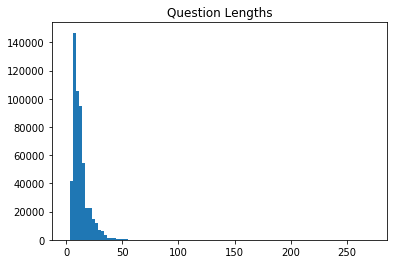

In [47]:
q_lengths = [len(q) for q in id2q.values()]
plt.hist(q_lengths, 100)
plt.title('Question Lengths')
plt.show()

In [59]:
1.*len([i for i in q_lengths if i>50])

1443.0

In [88]:
counts = train.is_duplicate.value_counts()
1.*counts[0]/(counts[0]+counts[1])

0.6308003205635586